## 데이터 준비

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

In [21]:
california = fetch_california_housing()
df = pd.DataFrame(california.data, columns=california.feature_names)
df["Target"] = california.target
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [23]:
data = torch.from_numpy(df.values).float()

x = data[:, :-1]
y = data[:, -1:]

print(x.size(), y.size())

torch.Size([20640, 8]) torch.Size([20640, 1])


In [24]:
ratios = [.6, .2, .2]

In [25]:
train_cnt = int(data.size(0) * ratios[0])
valid_cnt = int(data.size(0) * ratios[1])
test_cnt = data.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, valid_cnt, test_cnt))

Train 12384 / Valid 4128 / Test 4128 samples.


- 다음 코드를 통해 데이터셋의 랜덤 셔플링(random shuffling)후에 나누기를 수행한다.
- 추가로 주목해야할 부분은 x와 y에 대해서 각가 랜덤 선택 작업을 수행하는 것이 아니라 쌍으로 짝지어 수행이 된다.

In [26]:
# Shuffle before split.
indices = torch.randperm(data.size(0))
x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

# Split train, valid and test set with each count.
x = list(x.split(cnts, dim=0))
y = y.split(cnts, dim=0)

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

torch.Size([12384, 8]) torch.Size([12384, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])


- 학습데이터만을 활용하여 정규화를 진행해야 한다.
- 테스트와 검증 데이터까지 정규화를 한다면 정답을 보는 것과 같다.
- 학습 데이터인 x[0]에 대해서 표준 스케일링을 피팅시키고
- 이후에 해당 스케일러를 활용하여 학습(x[0]),검증(x[1]), 테스트(x[2])데이터에 대해 정규화를 진행하는 것을 볼 수 있다.

In [27]:
scaler = StandardScaler()
scaler.fit(x[0].numpy()) # You must fit with train data only.

x[0] = torch.from_numpy(scaler.transform(x[0].numpy())).float()
x[1] = torch.from_numpy(scaler.transform(x[1].numpy())).float()
x[2] = torch.from_numpy(scaler.transform(x[2].numpy())).float()

df = pd.DataFrame(x[0].numpy(), columns=california.feature_names)
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
12379,1.003343,-0.137526,0.796017,-0.147142,0.054145,-0.006601,-0.877116,0.887749
12380,-0.124103,-0.772575,0.249944,0.076941,0.427125,-0.040735,-1.143886,1.181574
12381,1.509148,-1.090100,0.440000,-0.228554,0.714239,-0.017148,0.868590,-1.432986
12382,-1.140629,1.847002,-0.505831,-0.017691,-0.746376,-0.040988,0.976236,-0.915054
12383,0.317588,1.053191,0.031919,-0.336668,0.152533,-0.013117,0.952834,-1.437967


In [28]:
model = nn.Sequential(
    nn.Linear(x[0].size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 4),
    nn.LeakyReLU(),
    nn.Linear(4, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y[0].size(-1)),
)

model

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)

In [29]:
optimizer = optim.Adam(model.parameters())

In [30]:
n_epochs = 4000
batch_size = 256
print_interval = 100

- 최저 검증 손실을 추적하기 위한 변수 lowest_loss와 
- 최적 검증 손실 값을 뱉어낸 모델을 저장히기 위한 best_model을 미리 생성한다.
- 이때 best_model에 단순히 현재 모델을 저장한다면 얇은 복사가 수행되어 주솟값이 저장되므로 깊은 복사를 통해 값 자체를 복사하여 저장해야 한다.
- 이를 위해서 copy 패키지의 deepcopy함수를 불러오는 것을 볼 수 있다.
- 또한 학습 조기 종료를 위한 세팅값과 가장 낮은 검증 손실 값을 뱉어낸 에포크를 저장하기 위한 변수인 lowest_epoch도 선언한다.

In [31]:
from copy import deepcopy

lowest_loss = np.inf
best_model = None

early_stop = 100
lowest_epoch = np.inf

In [32]:
train_history, valid_history = [], []

for i in range(n_epochs):
    # Shuffle before mini-batch split.
    indices = torch.randperm(x[0].size(0))
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    # |x_| = (total_size, input_dim)
    # |y_| = (total_size, output_dim)
    
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    # |x_[i]| = (batch_size, input_dim)
    # |y_[i]| = (batch_size, output_dim)
    
    train_loss, valid_loss = 0, 0
    y_hat = []
    
    for x_i, y_i in zip(x_, y_):
        # |x_i| = |x_[i]|
        # |y_i| = |y_[i]|
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()        
        train_loss += float(loss)

    train_loss = train_loss / len(x_)

    # You need to declare to PYTORCH to stop build the computation graph.
    with torch.no_grad():
        # You don't need to shuffle the validation set.
        # Only split is needed.
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)
        
        valid_loss = 0
        
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = F.mse_loss(y_hat_i, y_i)
            
            valid_loss += loss
            
            y_hat += [y_hat_i]
            
    valid_loss = valid_loss / len(x_)
    
    # Log each loss to plot after training is done.
    train_history += [train_loss]
    valid_history += [valid_loss]
        
    if (i + 1) % print_interval == 0:
        print('Epoch %d: train loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e' % (
            i + 1,
            train_loss,
            valid_loss,
            lowest_loss,
        ))
        
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        
        # 'state_dict()' returns model weights as key-value.
        # Take a deep copy, if the valid loss is lowest ever.
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print("There is no improvement during last %d epochs." % early_stop)
            break

print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))

# Load best epoch's model.
model.load_state_dict(best_model)

Epoch 100: train loss=3.4257e-01  valid_loss=3.6980e-01  lowest_loss=3.7023e-01
Epoch 200: train loss=3.2993e-01  valid_loss=3.6195e-01  lowest_loss=3.5796e-01
Epoch 300: train loss=3.2840e-01  valid_loss=3.6133e-01  lowest_loss=3.5682e-01
Epoch 400: train loss=3.2635e-01  valid_loss=3.5498e-01  lowest_loss=3.5437e-01
Epoch 500: train loss=3.2453e-01  valid_loss=3.5327e-01  lowest_loss=3.5340e-01
Epoch 600: train loss=3.2085e-01  valid_loss=3.5313e-01  lowest_loss=3.5169e-01
Epoch 700: train loss=3.2047e-01  valid_loss=3.5559e-01  lowest_loss=3.5032e-01
Epoch 800: train loss=3.1390e-01  valid_loss=3.4672e-01  lowest_loss=3.4584e-01
Epoch 900: train loss=3.0058e-01  valid_loss=3.3042e-01  lowest_loss=3.2983e-01
Epoch 1000: train loss=2.9647e-01  valid_loss=3.2725e-01  lowest_loss=3.2416e-01
Epoch 1100: train loss=2.9790e-01  valid_loss=3.2455e-01  lowest_loss=3.2023e-01
There is no improvement during last 100 epochs.
The best validation loss from epoch 1088: 3.2023e-01


<All keys matched successfully>

- 이처럼 학습 데이터셋을 미니배치로 나누어 한 바퀴 학습하고 나면 검증 데이터셋을 활용하여 검증 작어을 수행한다.
- 학습과 달리 검증 작업은 역전파를 활용하여 학습을 수행하지 않는다.
- 그래디언트를 계산할 필요가 없기 때문에 torch.no_grad함수를 호출하여 with 내부에서 검증 작업을 진행한다.
- 그러면 그래디언트를 계산하기 위한 배후 작업들이 없어지기 때문에 계산 오버헤드가 줄어들어 속도가 빨라지고 메모리 사용량도 줄어든다.

## 손실 곡선 확인


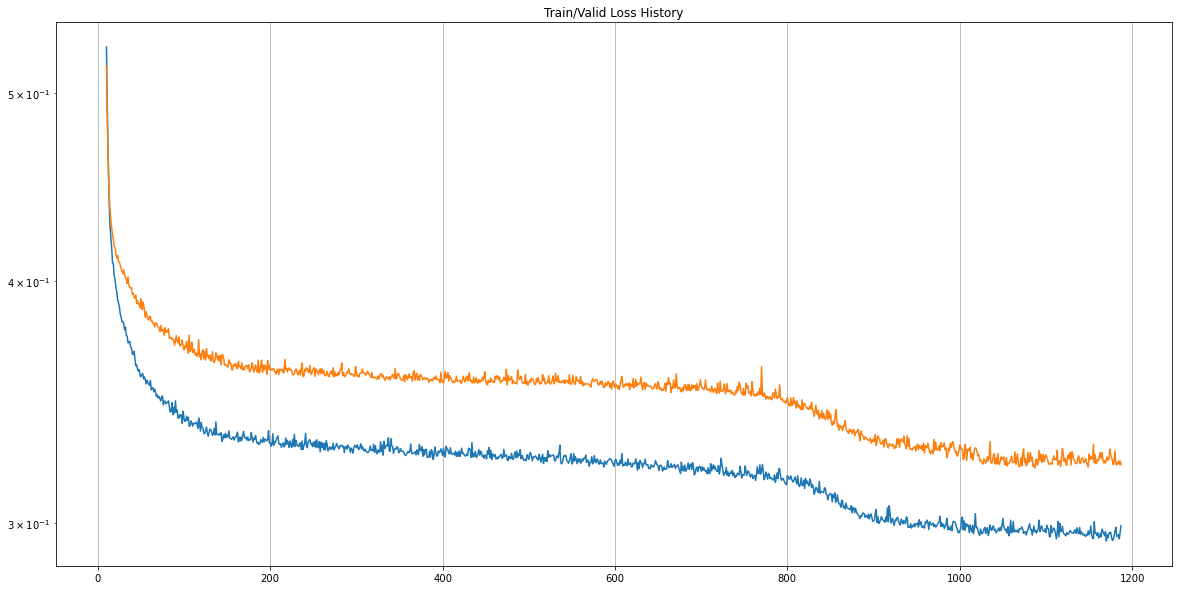

In [33]:
plot_from = 10

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title('Train/Valid Loss History')
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

## 결과확인

In [35]:
test_loss = 0
y_hat = []

with torch.no_grad():
    x_ = x[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        test_loss += loss 

        y_hat += [y_hat_i]

test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

sorted_history = sorted(zip(train_history, valid_history), key=lambda x:x[1])

print('Train loss : %.4e' % sorted_history[0][0])
print('Valid loss : %.4e' % sorted_history[0][1])
print('Test loss : %.4e' % test_loss)

Train loss : 2.9679e-01
Valid loss : 3.2023e-01
Test loss : 3.2882e-01


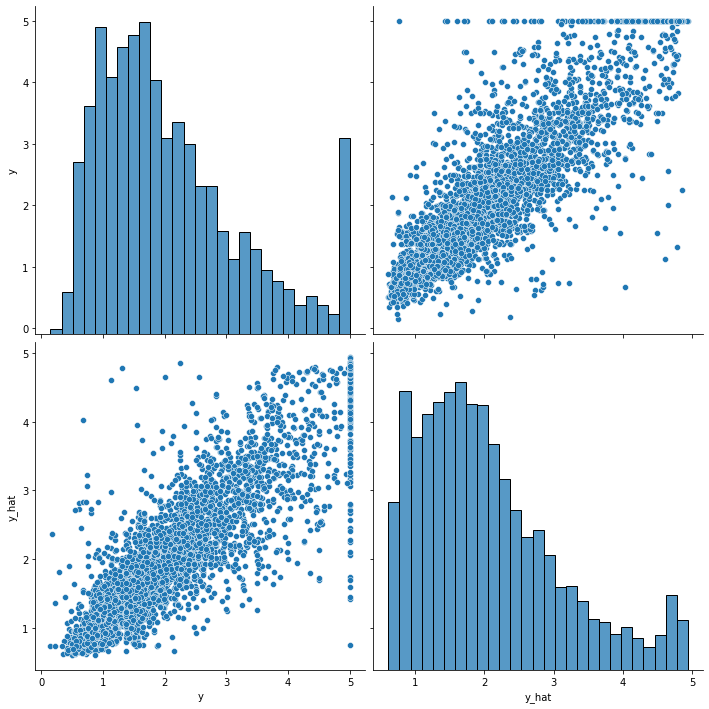

In [37]:
df = pd.DataFrame(torch.cat([y[2], y_hat], dim=1).detach().numpy(), columns=['y','y_hat'])
sns.pairplot(df, height=5)
plt.show()